## Import libraries, util functions and test image loading



In [ ]:
# Importing working libraries
import os
import cv2
import urllib3
import imutils
import numpy as np
from PIL import Image
from google.colab import drive # Comment when working in VSC
from matplotlib import pyplot as plt
from scipy.ndimage import morphology
from google.colab.patches import cv2_imshow # Comment when working in VSC
from scipy.ndimage import binary_dilation, binary_erosion

# Import from my google drive
drive.mount('/content/drive') # Comment when working in VSC

# Load image path to test functions
# For VSC:
#path_images = "./images" # It doesn't work in google colab because the file management is different.
# For Google Colab:
path_images = "/content/drive/MyDrive/Colab Notebooks/UAB Project/Computer Vision/UAB23-Computer-Vision-Labs/Lab 2/images"

Mounted at /content/drive


# Block 2. Non-Linear Filtering and Morphological operations.

While linear filters can be effective for certain tasks, they often come with limitations when dealing with specific types of noise or when aiming to achieve certain effects on the image.

### Objectives:

1. **Median Filter Implementation**:
 Implement the median filter and understand its significance in noise removal.

2. **Defect detection with morphological operations**:
 Implement the basic morphological operations of dilation and erosion. Then implement the derived operations from these basics. After all this, propose pipelines to detect precisely the defects on some images.

3. **Watermarking**:
 Propose a pipeline for image watermarking using any of the previous techniques (Linear filtering, Non-linear filtering, Fourier transform, Morphological operations).

4. **Watermark extraction challenge (extra points)**
 Given three images with embedded watermarks of varying complexity levels, employ a combination of techniques seen in the course (image enhancing, linear filtering, non-linear filtering, morphological operations, and Fourier analysis) to extract the watermarks.
 You should obtain the binary mask with legible watermark for each image.

 ***Note***: The Challenge Exercise can augment your total grade **for up to 2 points**. For example, if you score 6 on this lab and complete the challenge, your score will be boosted up to 2 points, depending on the solution (0.5 easy; 0.5 medium; 1 hard). The total lab grade remains capped at 10 points.

---

### Mandatory Questions:

- How does the median filter differ in functionality from the mean filter, and under what circumstances is it preferable to use it?
- Describe how a median filter works in the spatial domain.
- How does the window size of the median filter affect the output image?
- Can a median filter be implemented as a convolution operation? Explain why or why not.
- What are the basic morphological operations? Describe dilation and erosion in terms of structuring elements.
- How do morphological operations change the shape and size of objects in an image?
- What are some common derived morphological operations and where they are used for?
- What is the purpose of watermarking in image processing?
- What is the difference between visible and invisible watermarks?
- How could you utilize Fourier Transform for watermark embedding?


### Optional Deep Dive Questions:

- Beyond noise removal, can you think of any other applications where the median filter might be advantageous?
- Compare the computational complexity of median filtering with Gaussian filtering.
- Describe the process of top-hat and bottom-hat filtering. How can they be used for defect detection?
- Can morphological operations be applied to multi-channel images? Discuss the challenges.
- Discuss the concept of "hit-or-miss" transform in morphological operations. How can it be useful in defect detection?
- Explore the concept of morphological gradients. How can they be derived from the basic operations of erosion and dilation?
- In watermark extraction, are there any other techniques or methods (beyond the scope of this course) that might aid in making the extraction process more efficient or accurate? Research and discuss.
- Explore more robust watermarking and the techniques.

## Median filter

#### Objective:
Implement the median filter operation by hand and compare with linear blur filters.

---

#### Guideline:
1. Implement a function to perform the median filters over an image. Make sure to handle edge cases and allow for different kernel sizes. DO NOT USE LIBRARY IMPLEMENTATIONS.
2. Experiment with different kernel sizes and apply on various images.
3. Add different quantities of noise and analyze when an image is not recoverable.
4. Compare your hand-implemented method with libraries implementation.
5. Finally compare the median filter to the linear filter counterparts (gaussian / box filters) in order to explain how they differ.
---

#### Expected results:
- Your hand-implemented median filter.
- Qualitative comparison on different blurs

In [ ]:
def median_blur(image, kernel_size):

    # Checking parameters
    if not(isinstance(image, np.ndarray) or image is None):
        raise ValueError("The 'image' parameter must be a NumPy matrix")
    if not(len(image.shape) == 2):
      raise ValueError("The 'image' parameter must be in greyscale (3D -> 2D)")
    if not(image.shape[0] >= kernel_size[1] and image.shape[1] >= kernel_size[0]):
      raise ValueError("The 'kernel_size' size must be less than or equal to the image size in both dimensions")

    # Type conversion
    image = image.astype(np.float64)

    # Initialization of the output matrix
    output = np.zeros_like(image)

    # Half-kernel dimensions
    kh2,kw2 = kernel_size[1]//2,kernel_size[0]//2 # kernel_size = (kernel_width,kernel_height)

    # Iteration
    for i in range(0,output.shape[0]):
        for j in range(0,output.shape[1]):
            # Image region recovery
            image_region = image[i:i+kh2,j:j+kw2]
            # Calculating the scalar product between the image region and the kernel
            output[i,j] = np.median(image_region)

    # Result
    return output

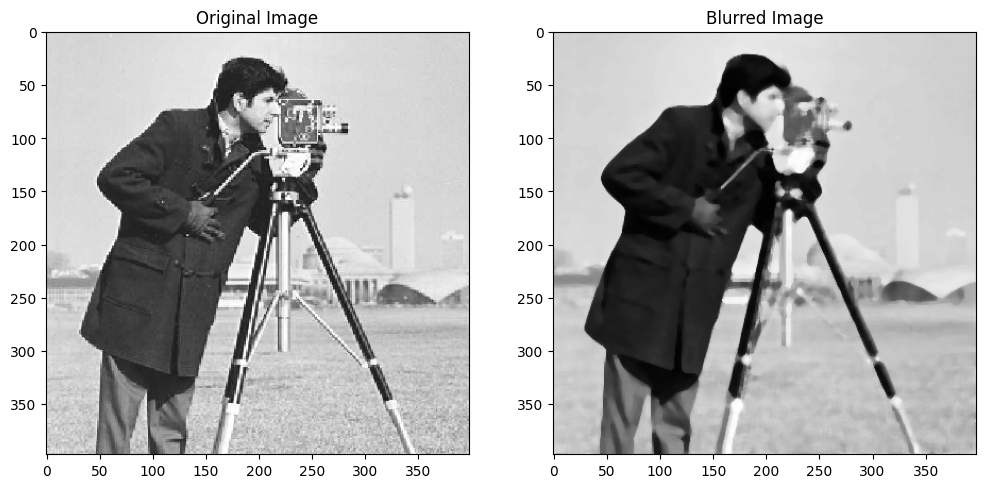

In [ ]:
# Image Preparation
path = os.path.join(path_images, "cameraman.png")
image_original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image_blur = median_blur(image_original, (15,15))

# Comparison Display
# Original Image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_original, cmap='gray')
plt.title('Original Image')

# Blurred Image
plt.subplot(1, 2, 2)
plt.imshow(image_blur, cmap='gray')
plt.title('Blurred Image')

# Display
plt.show()

## Morphological operators



#### Objective:
Implement the basic morphological operators seen in class and prove their properties.

Basic morphological operators:
 - Dilation
 - Erosion

Derived operations:   
 - Open
 - Close
 - Morphological gradient
 - Top hat (optional)
 - Bottom hat (optional)
 - Skeleton (optional)
 - Convex hull or perimeter (optional)

##### Prove each of the properties of dilation and erosion

- Translation Invariance (both)
- Anti-Extensive (Erosion)
- Extensive (Dilation)
- Idempotence (both)
- Monotonically increasing (both)

---

#### Guideline:
1. Implement a function to perform the erosion and dilation operations. DO NOT USE LIBRARY IMPLEMENTATIONS.
2. Implement the derived operations using the previous ones.
3. Apply different operators to dummy images and prove each of the properties of morphological operators.
4. Prove each one of the listed properties of erosion and dilation.

---

#### Expected results:
- Your hand-implemented functions for dilation, erosion, opening, closing & morphological gradient .
- Prove of each one of the properties (list them all)
- Example of each operation on dummy images (design your owns using openCV)

In [ ]:
# Dilation and Erosion

def dilation(image, structuring_element):
    height, width = image.shape
    s_height, s_width = structuring_element.shape
    pad_height, pad_width = s_height//2, s_width//2
    output = np.zeros_like(image)

    for i in range(0,height):
        for j in range(0,width):
            # Initialize the maximum value to the first pixel
            max_val = -np.inf #0
            for m in range(-pad_height,pad_height+1):
                for n in range(-pad_width,pad_width+1):
                    if structuring_element[m+pad_height][n+pad_width] == 1:
                      if (0<=i+m<=height-1) and(0<=j+n<=width-1):
                        max_val = max(max_val,image[i+m][j+n])
            output[i][j] = max_val

    return output

def erosion(image, structuring_element):
    height, width = image.shape
    s_height, s_width = structuring_element.shape
    pad_height, pad_width = s_height//2, s_width//2
    output = np.zeros_like(image)

    for i in range(0,height):
        for j in range(0,width):
            # Initialize the minimum value to the first pixel
            min_val = np.inf #1
            for m in range(-pad_height,pad_height+1):
                for n in range(-pad_width,pad_width+1):
                    if structuring_element[m+pad_height][n+pad_width] == 1:
                      if (0<=i+m<=height-1) and(0<=j+n<=width-1):
                        min_val = min(min_val,image[i+m][j+n])
            output[i][j] = min_val

    return output

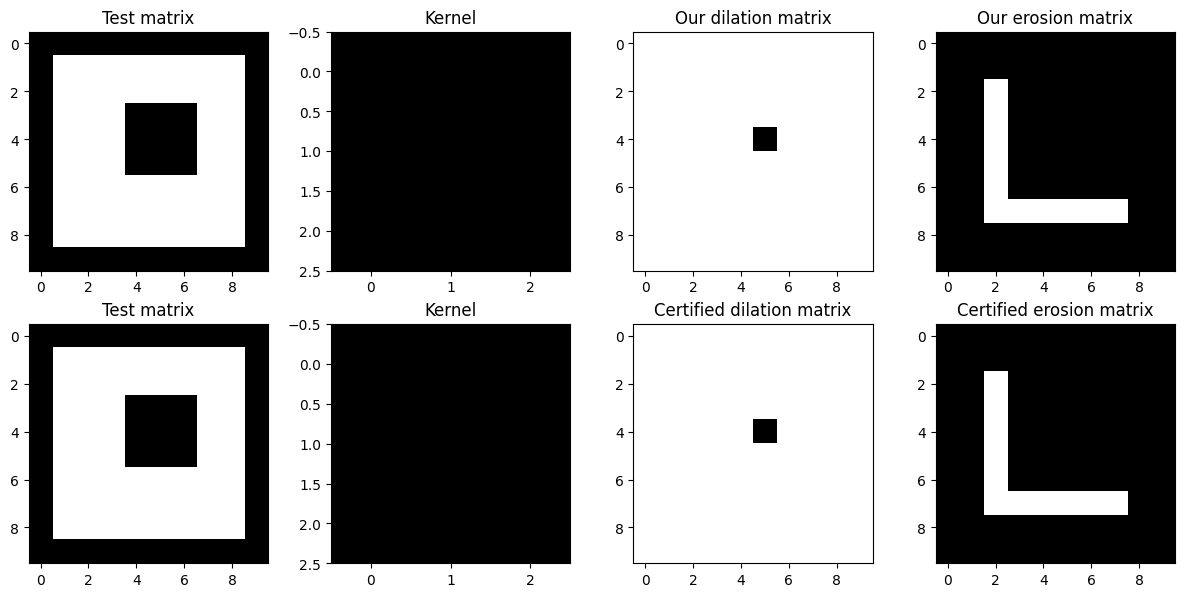

In [ ]:
# Dilation and erosion test on one example

test_matrix = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

kernel = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

# Matrix calculation
our_dilation_matrix = dilation(test_matrix, kernel)
our_erosion_matrix = erosion(test_matrix, kernel)
certified_dilation_matrix = binary_dilation(test_matrix, structure=kernel)
certified_erosion_matrix = binary_erosion(test_matrix, structure=kernel)

# Display preparation
our_matrix = [test_matrix, kernel, our_dilation_matrix, our_erosion_matrix,
              test_matrix, kernel, certified_dilation_matrix, certified_erosion_matrix]
titles = ["Test matrix", "Kernel", "Our dilation matrix", "Our erosion matrix",
          "Test matrix", "Kernel", "Certified dilation matrix", "Certified erosion matrix"]

# Display
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, (matrix, title) in enumerate(zip(our_matrix, titles)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(matrix, cmap='gray')
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [ ]:
# Dilation and erosion test on several randomly generated examples

iteration_count = 20
for _ in range(iteration_count):
  # Initialization of test matrices
  random_image = np.random.randint(2, size=(200, 200))
  random_kernel = np.random.randint(2, size=(5, 5))
  # Matrix calculation
  our_dilation_matrix = dilation(test_matrix, kernel)
  our_erosion_matrix = erosion(test_matrix, kernel)
  certified_dilation_matrix = binary_dilation(test_matrix, structure=kernel)
  certified_erosion_matrix = binary_erosion(test_matrix, structure=kernel)
  # Equality test
  if np.array_equal(our_dilation_matrix, certified_dilation_matrix):
    print("Same dilation matrix")
  else:
    print("Different dilation matrix")
  if np.array_equal(our_erosion_matrix, certified_erosion_matrix):
    print("Same erosion matrix")
  else:
    print("Different erosion matrix")

Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix
Same dilation matrix
Same erosion matrix


In [ ]:
def opening(image, structuring_element):
    # Erosion followed by dilation
    eroded_image = erosion(image, structure=structuring_element)
    opened_image = dilation(eroded_image, structure=structuring_element)
    return opened_image

def closing(image, structuring_element):
    # Dilation followed by erosion
    dilated_image = dilation(image, structure=structuring_element)
    closed_image = erosion(dilated_image, structure=structuring_element)
    return closed_image

def top_hat(image, structuring_element):
    # Top hat is the original image minus the opening
    return image - opening(image, structuring_element)

def black_hat(image, structuring_element):
    # Black hat is the closing minus the original image
    return closing(image, structuring_element) - image

def morphological_gradient(image, structuring_element):
    # Morphological gradient is dilation minus erosion
    return dilation(image, structuring_element) - erosion(image, structuring_element)

def convex_hull(image):
    pass

def skeletonize(image):
    pass

## Defect detection with Morphological operations


Objective:

Implement a pipeline for defect detection in a folder containing images. The pipelines should aim to obtain segmentation masks specifically on the defects using various image processing techniques seen in this course, focusing morphological operations.

---

Guideline:
- Inspect the images in the folder ```defects``` and identify the nature of defects.
- Design separate pipelines for different types of defects.
- For each pipeline, apply morphological operations and other techniques discussed in the course to isolate the defect and generate a segmentation mask.
- Evaluate the quality of the segmentation masks against ground truth using Intersection over Union (IoU) as a metric.

---

Expected results:
- Individual pipelines designed for each type of defect.
- Qualitative analysis showcasing the effectiveness of your pipeline in isolating defects.
- Quantitative analysis providing IoU scores for each pipeline when compared to ground truth masks in the same folder.

## Watermarking


#### Objective:
Use any of the previous techniques to apply a hard-to-removal watermark from to an image. After that you will try to reverse-engeneer your method and try to extract the text of the watermark you created.

---

#### Guideline:
1. Define a pipeline using the previous techniques (linear filtering, fourier transform, non-linear filtering, morphological operations, ...). You can use one or a combination of different techniques to produce a good pipeline.
2. Try to develop a method to extract the watermark (binary mask with the original watermark you introduced) by using the watermaked image and the original image.
3. Same as the previous one but relying only on the watermarked image. (You can't use the original image)
---

#### Expected results:
- A function that takes an image and a watermark (a binary image or a text) and returns the watermarked image.
- A pair of original image and the watermaked one
- A pair of a watermarked image and the watermark extracted (by using both original and watermaked image)
- A pair of a watermarked image and the watermark extracted (by using only the watermaked image)

In [ ]:
def apply_watermark(image, watermark_image, watermark_text=None):
    pass

def remove_watermark_easy(original_image, watermarked_image):
  pass


def remove_watermark_hard(watermarked_image):
  pass



## Watermark extraction challenge


#### Objective:
Create a binary mask where you can read the text of the watermark hidden on images on folder ```lab2_challenge```.  
Remember that this challenge counts as extra part of the lab and do not count of the optional points of this lab, so there's no guideline. Instead there's a hint on each level you can use to start designing your own method.


---

#### Hints:
  - Hints for each image:
    - Easy: Will edges and some post-processing be enough?
    - Medium: Equalizing the image correclty could make watermark more visible
    - Hard: Do you think image looks wierd enough to check fourier spece?

---

#### Expected results:
- A binary image with the extracted text (or at least somewhat readable) and the string of text you extracted on each one.